In [ ]:
import pickle
import numpy as np
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from skbio.stats.composition import clr
# ─── Load Data ───────────────────────────────────────────────────────────────
dataset_path_dict = {
    "embeddings": "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl",
    "neural": "/home/maria/LuckyMouse2/pixel_transformer_neuro/data/processed/hybrid_neural_responses_reduced.npy"
}

with open(dataset_path_dict['embeddings'], "rb") as f:
    embeddings_raw = pickle.load(f)
embeddings = embeddings_raw['natural_scenes']  # shape: (118, 1000)
print(embeddings.shape)
neural_data = np.load(dataset_path_dict["neural"])  # shape: (neurons, 118)

# ─── PCA ─────────────────────────────────────────────────────────────────────
pca = PCA(n_components=50,whiten=True)
X_all = pca.fit_transform(embeddings)  # shape: (118, 50)
print(X_all.shape)

# ─── Split Train/Test ────────────────────────────────────────────────────────
X_train = sm.add_constant(X_all[:-18])  # (100, 51)
X_test = sm.add_constant(X_all[-18:])   # (18, 51)

n_neurons = neural_data.shape[0]
#n_neurons=100
n_trials = 50
r2_test_scores = []

for i in range(n_neurons):
    # Get counts: shape (118,)
    counts = neural_data[i]

    # Split into training and test
    y_train = np.clip(np.round(counts[:-18]), 0, n_trials)
    y_test = np.clip(np.round(counts[-18:]), 0, n_trials)

    y_train_binomial = np.column_stack([y_train, n_trials - y_train])  # (100, 2)

    try:
        # Fit binomial GLM on training data
        model = sm.GLM(y_train_binomial, X_train, family=sm.families.Binomial())
        result = model.fit_regularized(alpha=10.0, L1_wt=0)

        # Predict probability of spiking on test set
        probs_pred = result.predict(X_test)  # shape: (18,)

        # Convert to predicted counts
        counts_pred = n_trials * probs_pred  # model's expected count
        r2_count = r2_score(y_test, counts_pred)
        r2_test_scores.append(r2_count)

        # Optional: also compute R² on probabilities, just to observe
        probs_true = y_test / n_trials
        r2_prob = r2_score(probs_true, probs_pred)

        print(f"Neuron {i}: R² (counts) = {r2_count:.4f} | R² (probs) = {r2_prob:.4f}")

        print("True counts:", y_test)
        print("Predicted counts:", counts_pred.round(2))

    except Exception as e:
        print(f"Neuron {i}: Error - {e}")
        r2_test_scores.append(None)


(118, 1000)
(118, 50)
Neuron 0: R² (counts) = -950.0184 | R² (probs) = -950.0184
True counts: [1. 5. 2. 1. 2. 2. 3. 2. 0. 3. 3. 2. 5. 5. 0. 2. 1. 0.]
Predicted counts: [53.02 58.01 57.77 53.63 47.81 52.04 44.69 48.57 46.1  43.83 52.59 55.66
 49.77 51.86 48.31 47.02 45.72 52.2 ]
Neuron 1: R² (counts) = -315.0141 | R² (probs) = -315.0141
True counts: [ 6.  4. 13. 10.  4.  7. 10. 10.  9. 11. 17.  8. 10.  5.  8.  7.  7.  7.]
Predicted counts: [101.69  63.36  92.44  56.63  33.93  62.94  70.94  50.19  33.97  39.15
  65.9   64.47  74.41  62.33  50.93  65.37  59.81  59.77]
Neuron 2: R² (counts) = -2104.9035 | R² (probs) = -2104.9035
True counts: [1. 1. 2. 2. 3. 0. 2. 4. 1. 2. 3. 3. 4. 1. 2. 1. 1. 1.]
Predicted counts: [51.23 54.74 54.25 45.21 46.01 48.72 62.1  49.   50.46 45.85 48.17 55.81
 52.09 47.83 48.33 66.36 45.98 63.02]
Neuron 3: R² (counts) = -666.6638 | R² (probs) = -666.6638
True counts: [0. 3. 4. 1. 0. 1. 1. 3. 4. 0. 2. 0. 0. 1. 3. 7. 2. 0.]
Predicted counts: [48.45 52.71 54.85 49.5

KeyboardInterrupt: 

In [6]:
np.where(np.array(r2_test_scores)>0)

(array([], dtype=int64),)

In [10]:
np.array(r2_test_scores)[np.where(np.array(r2_test_scores)>0)]

array([1.96863012e-01, 9.51850164e-02, 7.12873160e-01, 2.50930594e-05,
       6.90851935e-02, 1.24737135e-02, 4.35581949e-01, 2.54117540e-02,
       2.42984199e-02, 1.31498737e-01, 1.65711664e-01, 5.52357369e-03,
       4.43673483e-01, 3.62826744e-01, 2.86316769e-01, 4.40148824e-01])

(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 4.0000e+00, 7.0000e+00,
        1.4000e+01, 8.7000e+01, 3.6300e+02, 2.6940e+03, 3.6038e+04]),
 array([-4.96020000e+03, -4.46410871e+03, -3.96801743e+03, -3.47192614e+03,
        -2.97583485e+03, -2.47974356e+03, -1.98365228e+03, -1.48756099e+03,
        -9.91469701e+02, -4.95378414e+02,  7.12873160e-01]),
 <BarContainer object of 10 artists>)

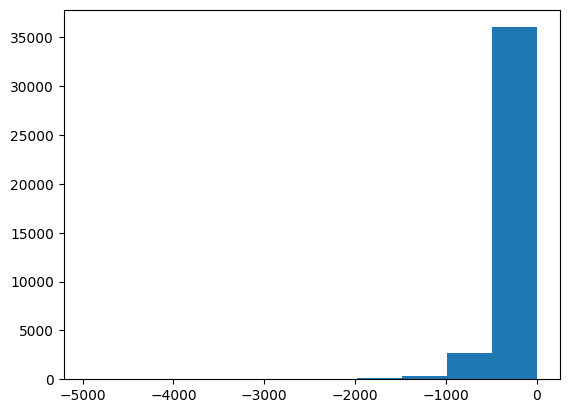

In [12]:
import  matplotlib.pyplot as plt
plt.hist(r2_test_scores)

In [14]:
from scipy.special import gammaln

def binomial_log_likelihood(k, n, p):
    eps = 1e-6  # Avoid log(0)
    p = np.clip(p, eps, 1 - eps)
    ll = (
        gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1) +
        k * np.log(p) + (n - k) * np.log(1 - p)
    )
    return ll

# After model.fit()
probs_pred = result.predict(X_test)
log_likelihood = binomial_log_likelihood(y_test, n_trials, probs_pred).sum()
#log_likelihoods_test.append(log_likelihood)

In [17]:
probs_pred

array([1.21356626e-01, 9.30090626e-02, 1.38016246e-01, 8.81814595e-02,
       1.14677768e-01, 2.84260896e-09, 5.23566588e-01, 1.13696492e-01,
       9.47034849e-04, 9.97777991e-02, 9.07241802e-02, 8.25259124e-02,
       1.35044163e-01, 5.20632154e-41, 7.26443696e-29, 1.01073495e-01,
       3.47720292e-01, 1.60324619e-01])

In [15]:
log_likelihood

np.float64(-323.49265069660737)

In [16]:
print(y_train)

[ 6.  3.  5.  5.  6.  4.  6.  9.  7.  6.  4.  2. 11.  7.  5.  8.  1.  6.
  5.  4.  3.  2.  2.  3.  7.  3.  4.  4.  7.  2.  7.  7.  4.  5.  2.  7.
  3.  5.  4.  5.  4.  8.  4.  4.  2.  5.  5.  5.  6.  4.  6.  2.  9.  4.
  7.  5.  8.  7.  7.  4.  5.  6.  4.  3.  2.  4.  4.  5.  7.  6.  7.  5.
  3.  4.  3.  8.  3.  1.  6.  7.  3. 11.  6.  4.  3.  4.  7.  3. 10.  4.
 11.  7.  1.  4.  4.  5.  5.  5.  2.  9.]
